In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#load JSON data
with open('data/user-wallet-transactions.json', 'r') as f:
    raw_data = pd.read_json(f)

In [58]:
# Normalize nested actionData
action_data_df = pd.json_normalize(raw_data['actionData'])
df = pd.concat([raw_data.drop(columns=['actionData']), action_data_df], axis=1)

In [59]:
# Convert timestamps
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
# Convert amount to float and normalize using asset price
df['amount'] = df['amount'].astype(float)
df['assetPriceUSD'] = df['assetPriceUSD'].astype(float)
df['amount_usd'] = df['amount'] * df['assetPriceUSD'] / (1e18)

In [60]:
# For USDC or stablecoins, adjust if amount unit is 6 decimals
usdc_mask = df['assetSymbol'].str.upper().str.contains('USDC|USDT')
df.loc[usdc_mask, 'amount_usd'] = df.loc[usdc_mask, 'amount'] * df.loc[usdc_mask, 'assetPriceUSD'] / 1e6

In [61]:
# Initial EDA
print("Sample Records:")
display(df.head())

print("Action Type Counts:")
print(df['action'].value_counts())

print("Unique Wallets:", df['userWallet'].nunique())

Sample Records:


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,__v,...,collateralAmount,collateralAssetPriceUSD,principalAmount,borrowAssetPriceUSD,collateralReserveId,collateralReserveSymbol,principalReserveId,principalReserveSymbol,datetime,amount_usd
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08-17 05:29:26,1987.663655
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-20 15:36:53,285.694480
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-24 09:28:33,0.000922
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-31 23:15:18,0.004230
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-19 15:25:07,0.502616


Action Type Counts:
action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64
Unique Wallets: 3497


In [81]:
# Feature Engineering Group by wallet
group = df.groupby('userWallet')

# Initialize feature DataFrame
features = pd.DataFrame(index=df['userWallet'].unique())

# Core transaction statistics
features['total_txns'] = group.size()
features['total_deposit_usd'] = df[df['action'] == 'deposit'].groupby('userWallet')['amount_usd'].sum()
features['total_borrow_usd'] = df[df['action'] == 'borrow'].groupby('userWallet')['amount_usd'].sum()
features['total_repay_usd'] = df[df['action'] == 'repay'].groupby('userWallet')['amount_usd'].sum()
features['total_redeem_usd'] = df[df['action'] == 'redeemunderlying'].groupby('userWallet')['amount_usd'].sum()
features['total_liquidations'] = df[df['action'] == 'liquidationcall'].groupby('userWallet').size()

# Unique behaviors
features['unique_assets'] = group['assetSymbol'].nunique()
features['num_actions'] = group['action'].nunique()

# Fill missing values with 0
features = features.fillna(0)

In [82]:
# Behavioral metrics
features['repay_to_borrow_ratio'] = features['total_repay_usd'] / (features['total_borrow_usd'] + 1)
features['net_flow'] = features['total_deposit_usd'] - features['total_borrow_usd'] - features['total_redeem_usd']
features['is_liquidated'] = features['total_liquidations'].apply(lambda x: 1 if x > 0 else 0)

In [83]:
# Recency metric: Days since last activity
last_txn_time = group['datetime'].max()
features['days_since_last_txn'] = (datetime.utcnow() - last_txn_time).dt.days
features['days_since_last_txn'] = features['days_since_last_txn'].fillna(features['days_since_last_txn'].max())
features = features.reset_index().rename(columns={'index': 'wallet'})

# Final fill and cleanup
features = features.fillna(0).reset_index().rename(columns={'userWallet': 'wallet'})

print(features.head())

   index                                      wallet  total_txns  \
0      0  0x00000000001accfa9cef68cf5371a23025b6d4b6           1   
1      1  0x000000000051d07a4fb3bd10121a343d85818da6           1   
2      2  0x000000000096026fb41fc39f9875d164bd82e2dc           2   
3      3  0x0000000000e189dd664b9ab08a33c4839953852c          17   
4      4  0x0000000002032370b971dabd36d72f3e5a7bf1ee         399   

   total_deposit_usd  total_borrow_usd  total_repay_usd  total_redeem_usd  \
0        1987.663655          0.000000         0.000000          0.000000   
1         285.694480          0.000000         0.000000          0.000000   
2           0.005152          0.000000         0.000000          0.000000   
3           0.000000          0.000000         0.000000        989.360648   
4      925490.696960     130355.754756     70150.263791     824037.577815   

   total_liquidations  unique_assets  num_actions  repay_to_borrow_ratio  \
0                 0.0              1            1   

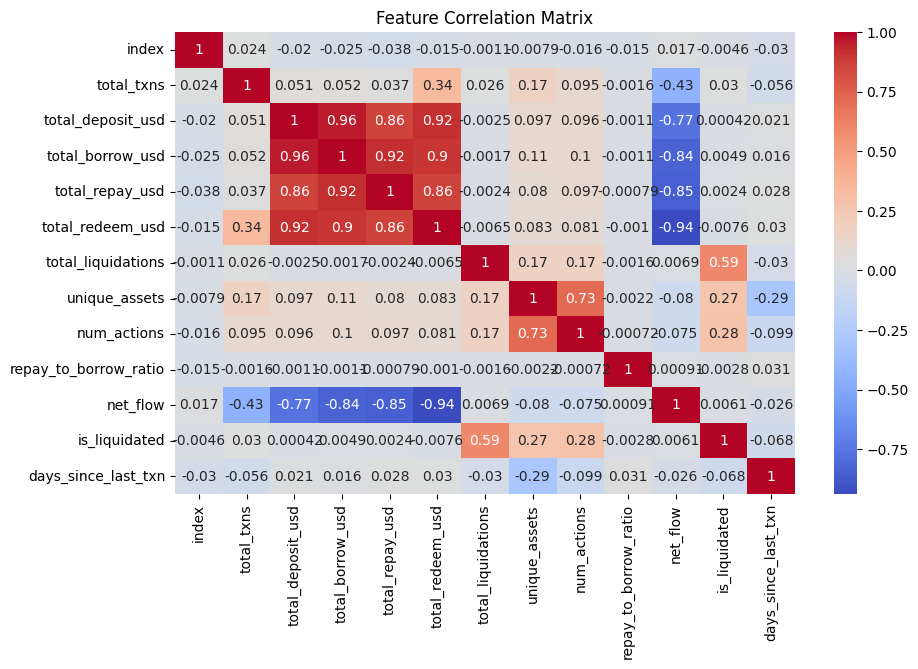

In [84]:
# Remove wallet column (string) before computing correlation
corr_data = features.drop(columns=['wallet'])

# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


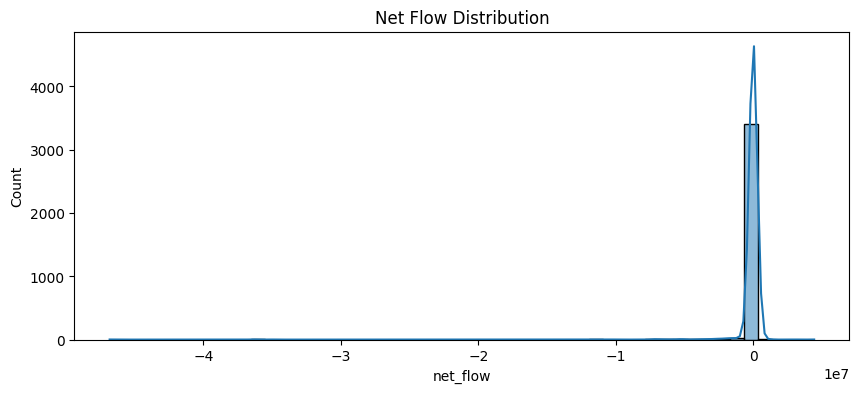

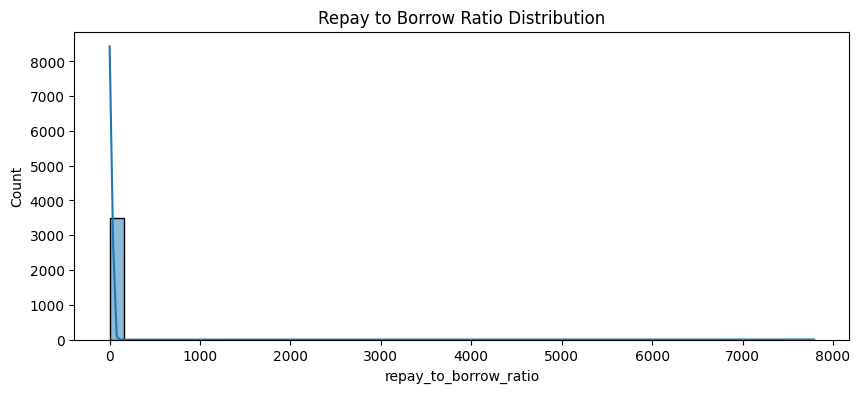

In [91]:
if 'net_flow' not in features.columns:
    features['net_flow'] = features['total_deposit_usd'] - features['total_borrow_usd'] - features['total_redeem_usd']
    features['repay_to_borrow_ratio'] = features['total_repay_usd'] / (features['total_borrow_usd'] + 1)
# Distribution plots
plt.figure(figsize=(10, 4))
sns.histplot(features['net_flow'], bins=50, kde=True)
plt.title("Net Flow Distribution")
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(features['repay_to_borrow_ratio'], bins=50, kde=True)
plt.title("Repay to Borrow Ratio Distribution")
plt.show()

In [86]:
import os
# Create 'data' directory if it doesn't exist
os.makedirs('data', exist_ok=True)
#Save features for model
features.reset_index(inplace=True)
features.to_csv('data/wallet_features.csv', index=False)
print("Features saved to wallet_features.csv")

Features saved to wallet_features.csv


In [87]:
duplicates = df.duplicated(subset=['userWallet', 'txHash', 'action'])
print(f"Duplicate records: {duplicates.sum()}")  # df = df.drop_duplicates(subset=['userWallet', 'txHash', 'action'])

Duplicate records: 787


In [88]:
print(df.columns.tolist())

['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', '__v', 'createdAt', 'updatedAt', 'type', 'amount', 'assetSymbol', 'assetPriceUSD', 'poolId', 'userId', 'toId', 'borrowRateMode', 'borrowRate', 'variableTokenDebt', 'stableTokenDebt', 'callerId', 'useATokens', 'repayerId', 'liquidatorId', 'collateralAmount', 'collateralAssetPriceUSD', 'principalAmount', 'borrowAssetPriceUSD', 'collateralReserveId', 'collateralReserveSymbol', 'principalReserveId', 'principalReserveSymbol', 'datetime', 'amount_usd']


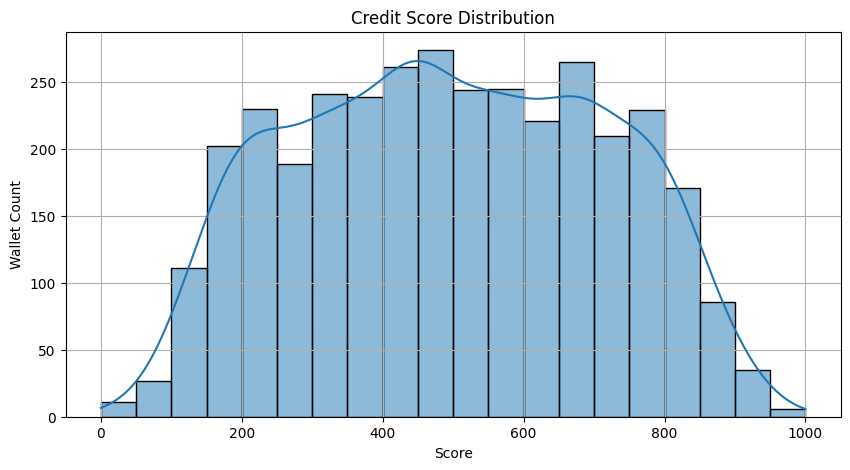

In [94]:
scores = pd.read_csv("data/wallet_scores.csv")

plt.figure(figsize=(10, 5))
sns.histplot(scores['credit_score'], bins=20, kde=True)
plt.title("Credit Score Distribution")
plt.xlabel("Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.savefig("assets/score_distribution.png")  # Make sure /assets exists
plt.show()